In [86]:
import os
import glob
import datetime

# Define the directory to search for text files
directory = '/Users/Feifei/Box/BR_remote_sensing/FastRivers/AmuDarya_Kerki/rivgraph'  # Replace with your desired directory path

# Initialize lists for data and datetime values
datetimes = []
data = []

# Iterate over each directory and its subdirectories
for root, dirs, files in os.walk(directory):
    # Find all text files starting with "output_eBI" in the current directory
    file_paths = glob.glob(os.path.join(root, "output_eBI*.txt"))

    # Sort the file paths alphabetically
    file_paths.sort()

    # Iterate over each file path
    for file_path in file_paths:
        # Read the text file into an array, skipping the first line
        arr = np.loadtxt(file_path, skiprows=1)
        data.append(arr)

        # Read the first line of the file as a datetime value
        with open(file_path, 'r') as file:
            first_line = file.readline().strip()  # Read the first line

            if first_line.startswith('Date:'):
                datetime_str = first_line.split(": ")[1]  # Extract the datetime string
                #datetime_value = datetime.datetime.strptime(datetime_str, '%B %Y').strftime('%b %Y')  # Convert to month and year string
                datetime_value = datetime.datetime.strptime(datetime_str, '%B %Y').strftime('%Y')  # Convert to month and year string
                datetimes.append(datetime_value)

# Convert the lists to arrays
data_combined = np.array(data)
datetimes_combined = np.array(datetimes)

# Reshape the data to have shape (18, 1)
data_reshaped = data_combined.reshape(30, 1)
datetimes_combined = datetimes_combined.reshape(30, 1)


C:\Users\Feifei\AppData\Local\Temp\ipykernel_21856\230689507.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_combined = np.array(data)


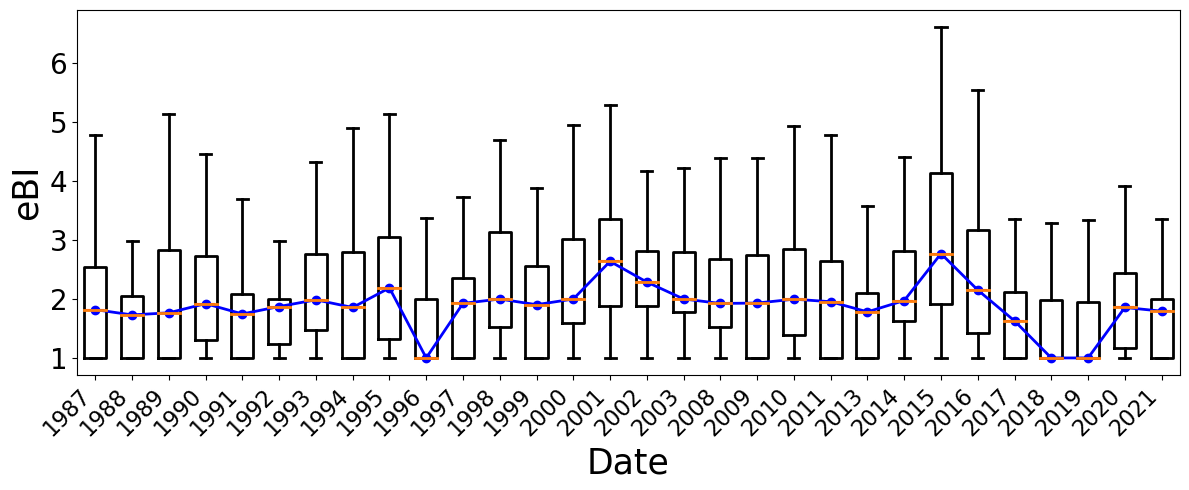

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting the boxplots
fig, ax = plt.subplots(figsize=(12, 5))  # Adjust the figure size as needed

medians = []  # Store the median values
positions = np.arange(1, len(datetimes_combined) + 1)
for i, data_row in enumerate(data_reshaped):
    boxplot = ax.boxplot(data_row, positions=[i + 1], widths=0.6, labels=[datetimes_combined[i]],showfliers=False)

    # Set the linewidth for each component of the boxplot
    for component in boxplot.keys():
        plt.setp(boxplot[component], linewidth=2)  # Set the linewidth to 2

    # Get the median values
    median = boxplot["medians"][0].get_ydata()[0]
    medians.append(median)

    # Add a line through the median
    ax.hlines(median, i + 0.75, i + 1.25, color='red')

# Draw a line connecting medians
ax.plot(positions, medians, color='blue', marker='o', linestyle='-', linewidth=2)


# Adding labels and title
plt.xlabel('Date', fontsize=25)
plt.ylabel('eBI', fontsize=25)

# Customizing x-axis tick labels
xtick_labels = [date.split() for date in datetimes_combined.flatten()]  # Split the dates into two lines
xtick_labels = ['\n'.join(date) for date in xtick_labels]  # Join the split lines with a line break
plt.xticks(positions, xtick_labels, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=20)
# Display the plot
plt.tight_layout()  # Adjust the spacing between plot elements
plt.show()
plt.savefig('/Users/Feifei/Box/PlanetClassification/Tuotuo/eBI.png')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the Excel file
file_path = '/Users/Feifei/Box/PlanetClassification/Lietal_2021_data.xlsx'  # Replace with the path to your Excel file
sheet_name = 'Fig.4'
dataframe = pd.read_excel(file_path, sheet_name=sheet_name)


# Extract the "Year" and "Runoff (Q)" columns
year_column = dataframe['Year'].values[3:].astype(int)
runoff_column = dataframe['Runoff (Q)'].values[3:].astype(float)
sed_column = dataframe['Suspended sediment flux (SSF)'].values[3:].astype(float)

# Create a figure with a larger width
plt.figure(figsize=(15, 3))  # Adjust the width (first value) as needed

# Create the first subplot for the "Runoff" column
ax1 = plt.subplot(1, 1, 1)
ax1.plot(year_column, runoff_column, marker='o', color='blue',linewidth=2)
ax1.set_xlabel('Year',fontsize=20)
ax1.set_ylabel('Q (km3/yr)',fontsize=20)

# Set xtick positions and labels
#xtick_positions = [year for year in year_column if year % 2 == 1]  # Example: xticks for even years
xtick_labels = [str(year) for year in xtick_positions]
plt.xticks(xtick_positions, xtick_labels,fontsize=15)
plt.yticks(fontsize=15) 

# Create the second subplot for the "Suspended sediment flux (SSF)" column
ax2 = ax1.twinx()
ax2.plot(year_column, sed_column, marker='o', color='red',linewidth=2)
ax2.set_ylabel('SSF (Mt/yr)',fontsize=20)
plt.yticks(fontsize=15) 
# Customize the plot
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, ['Runoff (Q)', 'Suspended sediment flux (SSF)'], loc='upper left',fontsize=15)


# Add a vertical marker at x=2009
plt.axvline(x=2009, color='orange', linestyle='--')


# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the Excel file
file_path = '/Users/Feifei/Box/PlanetClassification/Lietal_HMA.xlsx'  # Replace with the path to your Excel file
sheet_name = 'Fig.2'
dataframe = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract the desired columns
desired_columns = ['Year', 'Q percentage anomaly (%)', 'Qs percentage anomaly (%)', 'Temperature anomaly (℃)']
extracted_data = dataframe[desired_columns]

# Set figure size
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot the Q percentage anomaly
ax1.plot(extracted_data['Year'], extracted_data['Q percentage anomaly (%)'], color='blue',label='Runoff (Q)')
ax1.plot(extracted_data['Year'], extracted_data['Qs percentage anomaly (%)'], color='orange',label='Sediment flux (Qs))')
ax1.set_xlabel('Year',fontsize=15)
ax1.set_ylabel('Percentage Anomaly', fontsize=15)
plt.yticks(fontsize=15) 
plt.xticks(fontsize=15) 


# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(extracted_data['Year'], extracted_data['Temperature anomaly (℃)'], color='red', label='Temperature (℃)')
plt.yticks(fontsize=15) 
ax2.set_ylabel('Temperature Anomaly (℃)',fontsize=15)

# Combine the legends and move it to the left
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize='large')

# Display the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Feifei/Box/PlanetClassification/Lietal_HMA.xlsx'

In [ ]:
# plot monthly discharge data

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv("/Users/Feifei/Box/PlanetClassification/Tuotuo/Q_monthly.csv")

# Extract the desired columns
precipitation = data["Precipitation (mm)"]
discharge = data["Discharge (m^3/s)"]

# Define the x-axis labels
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot the precipitation as a line plot
ax1.plot(months, precipitation, marker="o", color="blue", label="Precipitation (mm)")
ax1.set_xlabel("Month", fontsize=20)
ax1.set_ylabel("Precipitation (mm)", color="blue",fontsize=20)
ax1.tick_params(axis="y", labelcolor="blue",labelsize=20)

ax1.tick_params(axis="x", labelsize=17)

# Create a second y-axis for discharge as a bar plot
ax2 = ax1.twinx()
ax2.bar(months, discharge, color="red", alpha=0.5, label="Discharge (m$^3$/s)")
ax2.set_ylabel("Discharge (m$^3$/s)", color="red",fontsize=20)
ax2.tick_params(axis="y", labelcolor="red",labelsize=20)

# Display the legends
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels,fontsize=15)

# Show the plot
plt.show()

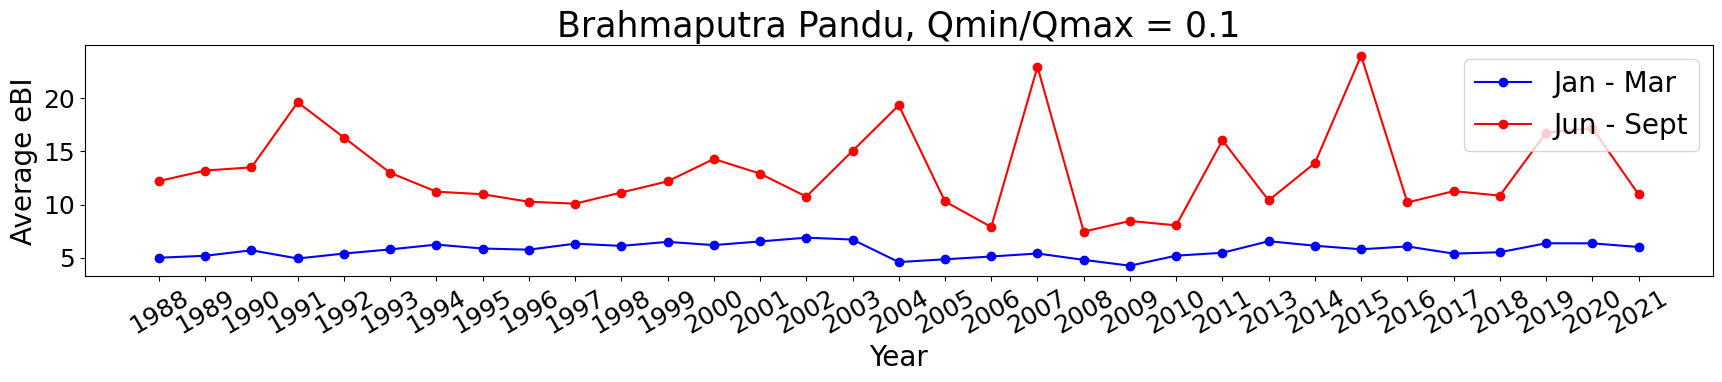

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"C:\Users\Feifei\GEE_watermasks-master\ebi\Brahmaputra_Pandu\rivgraph\eBI_results.csv"

# Load CSV into a Pandas DataFrame with a header
df = pd.read_csv(csv_filepath, header=None)

# Calculate the average for each row excluding the 'year' column
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1)

# Extract the year and month from the first column (file names)
df['year'] = df[0].apply(lambda x: str(x).split('_')[1] if isinstance(x, str) else '')
df['month'] = df[0].apply(lambda x: str(x).split('_')[2][:2] if isinstance(x, str) else '')

# Create a new column for labeling based on the condition
df['label'] = df.apply(lambda row: f"{row['year']}\n{'Jan' if row['month'] == '01' else 'Jun'}", axis=1)

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()
df_grouped.interpolate(axis=0, inplace=True)

# Set the figure size before plotting
plt.figure(figsize=(21, 3))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['01'], marker='o', color='blue', label='January', linestyle='-')

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['06'], marker='o', color='red', label='Non-January', linestyle='-')



plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('Brahmaputra Pandu, Qmin/Qmax = 0.1', fontsize=25)
plt.xticks(rotation=30, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Jan - Mar', 'Jun - Sept'], loc='upper right', fontsize=20)
# Show the plot
plt.show()


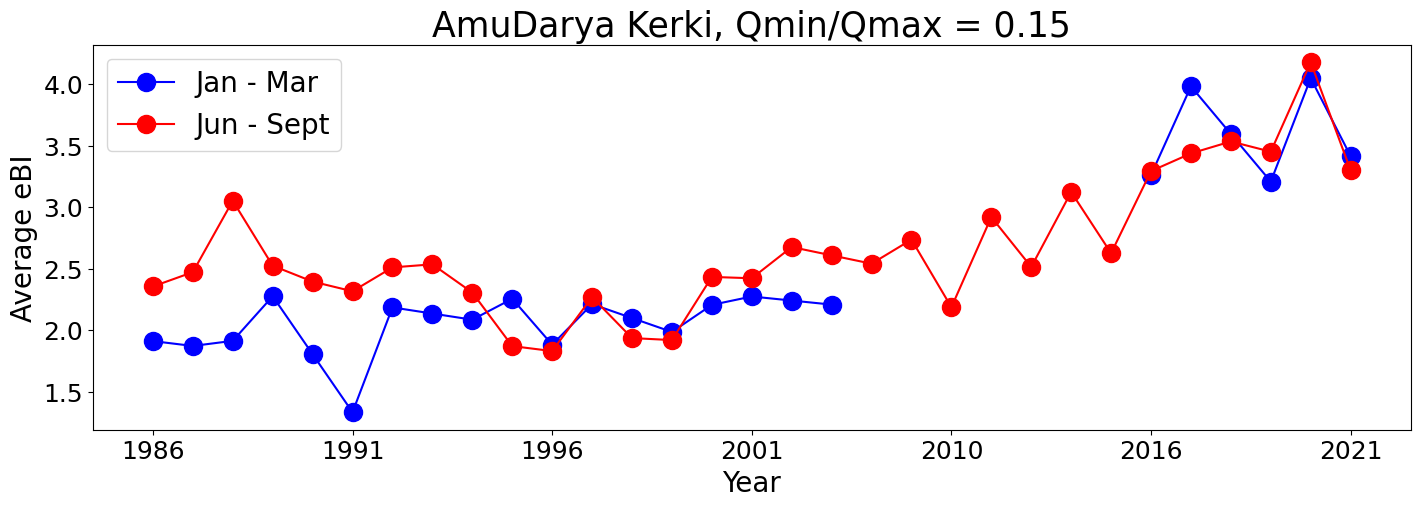

In [ ]:
# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"c:\Users\Feifei\GEE_watermasks-master\ebi\AmuDarya_Kerki\rivgraph\eBI_results.csv"

# Load CSV into a Pandas DataFrame with a header
df = pd.read_csv(csv_filepath, header=None)

# Calculate the average for each row excluding the 'year' column
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1)

# Extract the year and month from the first column (file names)
df['year'] = df[0].apply(lambda x: str(x).split('_')[1] if isinstance(x, str) else '')
df['month'] = df[0].apply(lambda x: str(x).split('_')[2][:2] if isinstance(x, str) else '')

# Create a new column for labeling based on the condition
df['label'] = df.apply(lambda row: f"{row['year']}\n{'Jan' if row['month'] == '01' else 'Jun'}", axis=1)

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()

# Interpolate NaN values for each column (month)
df_grouped.interpolate(axis=0, inplace=True)
df_grouped.loc['2008':'2015', '01'] = float('nan')

# Set the figure size before plotting
plt.figure(figsize=(17, 5))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['01'], marker='o', color='blue', label='January', linestyle='-', markersize=13)

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['06'], marker='o', color='red', label='Non-January', linestyle='-', markersize=13)



plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('AmuDarya Kerki, Qmin/Qmax = 0.15', fontsize=25)
plt.xticks(df_grouped.index[::5], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Jan - Mar', 'Jun - Sept'], loc='upper left', fontsize=20)
# Show the plot
plt.show()

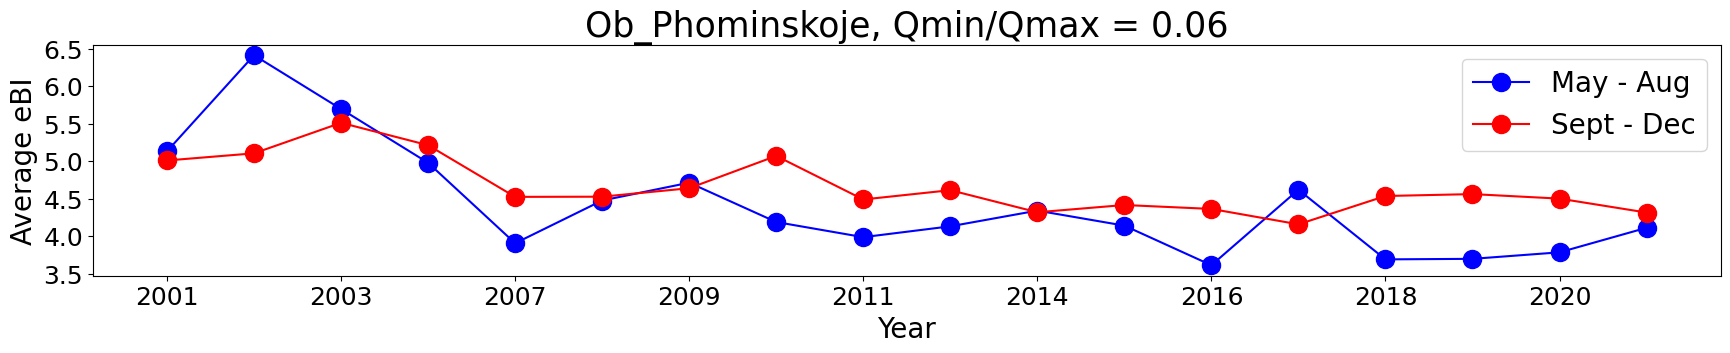

In [ ]:
# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"C:\Users\Feifei\GEE_watermasks-master\ebi\Ob_Phominskoje\rivgraph\eBI_results.csv"

# Load CSV into a Pandas DataFrame with a header
df = pd.read_csv(csv_filepath, header=None)

# Calculate the average for each row excluding the 'year' column
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1)

# Extract the year from the first column (file names)
df['year'] = df[0].apply(lambda x: ''.join(char for char in str(x) if char.isdigit())[:4] if isinstance(x, str) else '')

df['month'] = df[0].apply(lambda x: str(x).split('_')[3][:2] if isinstance(x, str) else '')

# Create a new column for labeling based on the condition
df['label'] = df.apply(lambda row: f"{row['year']}\n{'Jan' if row['month'] == '12' else 'Jun'}", axis=1)

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()

# Interpolate NaN values for each column (month)
df_grouped.interpolate(axis=0, inplace=True)

# Set the figure size before plotting
plt.figure(figsize=(21, 3))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['12'], marker='o', color='blue', label='January', linestyle='-', markersize=13)

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['09'], marker='o', color='red', label='Non-January', linestyle='-', markersize=13)



plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('Ob_Phominskoje, Qmin/Qmax = 0.06', fontsize=25)
plt.xticks(df_grouped.index[::2], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['May - Aug', 'Sept - Dec'], loc='upper right', fontsize=20)
# Show the plot
plt.show()

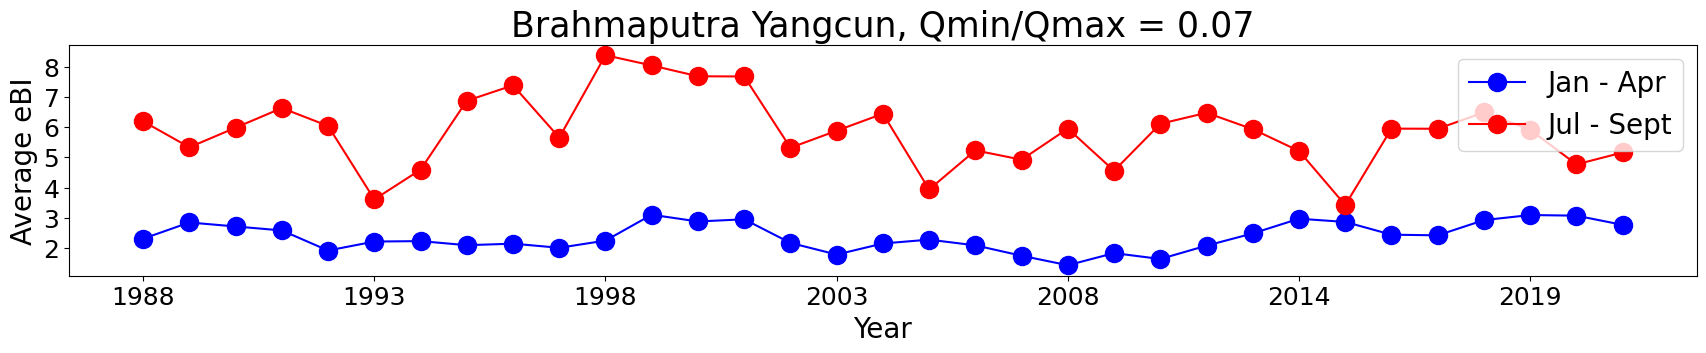

In [ ]:
# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"C:\Users\Feifei\GEE_watermasks-master\ebi\Brahmaputra_Yangcun\rivgraph\eBI_results.csv"



df = pd.read_csv(csv_filepath, header=None)
# Calculate the average for each row excluding the 'year' column
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1)

# Extract the year and month from the first column (file names)
df['year'] = df[0].apply(lambda x: str(x).split('_')[1] if isinstance(x, str) else '')
df['month'] = df[0].apply(lambda x: str(x).split('_')[2][:2] if isinstance(x, str) else '')

# Create a new column for labeling based on the condition
df['label'] = df.apply(lambda row: f"{row['year']}\n{'Jan' if row['month'] == '01' else 'Jul'}", axis=1)

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()

# Interpolate NaN values for each column (month)
df_grouped.interpolate(axis=0, inplace=True)

# Set the figure size before plotting
plt.figure(figsize=(21, 3))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['01'], marker='o', color='blue', linestyle='-', markersize=13)

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['07'], marker='o', color='red', linestyle='-', markersize=13)

plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('Brahmaputra Yangcun, Qmin/Qmax = 0.07', fontsize=25)
plt.xticks(df_grouped.index[::5], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Jan - Apr', 'Jul - Sept'], loc='upper right', fontsize=20)
# Show the plot
plt.show()


In [ ]:
# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Solimoes_Tabatinga\rivgraph\eBI_results.csv"



df = pd.read_csv(csv_filepath, header=None)
# Calculate the average for each row excluding the 'year' column
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1)

# Extract the year and month from the first column (file names)
df['year'] = df[0].apply(lambda x: str(x).split('_')[1] if isinstance(x, str) else '')
df['month'] = df[0].apply(lambda x: str(x).split('_')[2][:2] if isinstance(x, str) else '')

# Create a new column for labeling based on the condition
df['label'] = df.apply(lambda row: f"{row['year']}\n{'Jan' if row['month'] == '01' else 'Jul'}", axis=1)

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()

# Interpolate NaN values for each column (month)
df_grouped.interpolate(axis=0, inplace=True)

# Set the figure size before plotting
plt.figure(figsize=(21, 3))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['01'], marker='o', color='blue', linestyle='-', markersize=13)

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['07'], marker='o', color='red', linestyle='-', markersize=13)

plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('Brahmaputra Yangcun, Qmin/Qmax = 0.07', fontsize=25)
plt.xticks(df_grouped.index[::5], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Jan - Apr', 'Jul - Sept'], loc='upper right', fontsize=20)
# Show the plot
plt.show()

IndexError: list index out of range

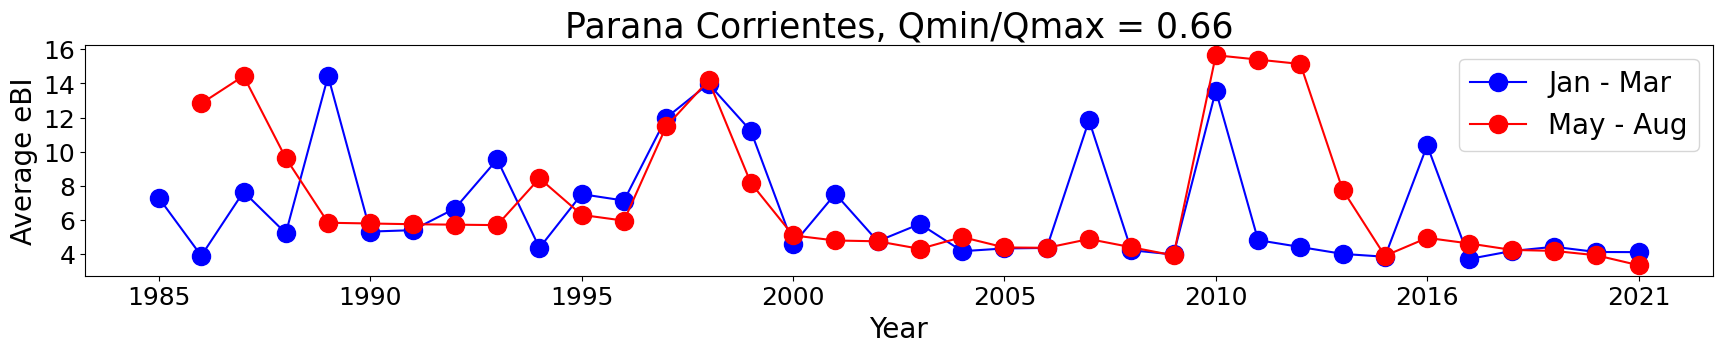

In [ ]:
# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"C:\Users\Feifei\GEE_watermasks-master\ebi\Parana_Corrientes\rivgraph\eBI_results.csv"


df = pd.read_csv(csv_filepath, header=None)
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1, skipna=True)

# Extract the year and month from the first column (file names)
df['year'] = df[0].apply(lambda x: str(x).split('_')[1] if isinstance(x, str) else '')
df['month'] = df[0].apply(lambda x: str(x).split('_')[2][:2] if isinstance(x, str) else '')

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()

# Interpolate NaN values for each column (month)
df_grouped.interpolate(axis=0, inplace=True)

# Set the figure size before plotting
plt.figure(figsize=(21, 3))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['01'], marker='o', color='blue', linestyle='-', markersize=13)

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['05'], marker='o', color='red', linestyle='-', markersize=13)


plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('Parana Corrientes, Qmin/Qmax = 0.66', fontsize=25)
plt.xticks(df_grouped.index[::5], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Jan - Mar', 'May - Aug'],loc='upper right', fontsize=20)
# Show the plot
plt.show()

### preprocess water discharge data: combine any daily GRDC data into monthly data, convert to csv format 


In [571]:


# Define input and output directories
input_dir = r"C:\Users\Feifei\Box\BR_remote_sensing\water_discharge_data\unprocessed"
output_dir = r"C:\Users\Feifei\Box\BR_remote_sensing\water_discharge_data\processed"

# Function to process Q_monthly files
def process_Q_monthly(file_path):
        with open(file_path, 'r', encoding='latin1') as file:
            # Read the file line by line until you find the line that contains "DATA"
            for i, line in enumerate(file):
                if 'lines' in line:
                    # Once "DATA" is found, the number of rows to skip is i+1 (0-indexed)
                    skip_rows = i + 2
                    # Read the CSV file using the dynamically determined number of rows to skip
                    df = pd.read_csv(file_path, skiprows=skip_rows, encoding='latin1', delimiter=';', skipinitialspace=True)
                    df['Original'] = df['Original'].replace(-999.000, pd.NA)
                    df['month'] = pd.to_datetime(df['YYYY-MM-DD']).dt.month
                    df['year'] = pd.to_datetime(df['YYYY-MM-DD']).dt.year
                    df['date'] = df['month'].astype(str) + '/1/' + df['year'].astype(str)
                    df = df.rename(columns={'Original': 'Q'})
                    df_new = df[['date', 'Q']]

        return df_new

# Function to process Q_Day files
def process_Q_day(file_path):
        with open(file_path, 'r', encoding='latin1') as file:
            # Read the file line by line until you find the line that contains "lines"
            for i, line in enumerate(file):
                if 'lines' in line:
                    skip_rows = i + 2
                    df = pd.read_csv(file_path, skiprows=skip_rows, encoding='latin1', delimiter=';', skipinitialspace=True)
                    df['Value'] = df['Value'].replace(-999.000, pd.NA)
                    df['month'] = pd.to_datetime(df['YYYY-MM-DD']).dt.month
                    df['year'] = pd.to_datetime(df['YYYY-MM-DD']).dt.year

                    df_grouped = df.groupby(['year', 'month'])['Value'].mean().reset_index()
                    df_grouped['date'] = df_grouped['month'].astype(str) + '/1/' + df_grouped['year'].astype(str)
                    df_grouped = df_grouped.rename(columns={'Value': 'Q'})
                    df_grouped = df_grouped[['date', 'Q']]
        return df_grouped

# Function to process OHDB files
def process_OHDB(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    df_grouped = df.groupby(['year', 'month'])['Q'].mean().reset_index()
    df_grouped['date'] = df_grouped['month'].astype(str) + '/1/' + df_grouped['year'].astype(str)
    return df_grouped[['date', 'Q']]

# Iterate over files in the input directory
for file_name in os.listdir(input_dir):
    file_path = os.path.join(input_dir, file_name)
    output_file_path = os.path.join(output_dir, file_name.replace('.txt', '.csv'))
    if file_name.endswith('Q_Month.txt'):
        df = process_Q_monthly(file_path)
        df.to_csv(output_file_path, index=False)
    if file_name.endswith('Q_Day.txt'):
        df = process_Q_day(file_path)
        df.to_csv(output_file_path, index=False)
    elif file_name.startswith('OHDB'):
        df = process_OHDB(file_path)
        df.to_csv(output_file_path, index=False)
    else:
        continue



          date       Q
0     6/1/1954   184.0
1     7/1/1954   401.0
2     8/1/1954   974.0
3     9/1/1954  1387.0
4    10/1/1954  1699.0
..         ...     ...
458   8/1/1992   427.0
459   9/1/1992   857.0
460  10/1/1992  1238.0
461  11/1/1992  1349.0
462  12/1/1992  1224.0

[463 rows x 2 columns]
          date       Q
0     4/1/1951   150.0
1     5/1/1951   470.0
2     6/1/1951   580.0
3     7/1/1951   996.0
4     8/1/1951  1070.0
..         ...     ...
343  11/1/1979  1075.0
344  12/1/1979   349.0
345   1/1/1980   223.0
346   2/1/1980   186.0
347   3/1/1980   171.0

[348 rows x 2 columns]
         date       Q
0    5/1/1933   170.0
1    6/1/1933   235.0
2    7/1/1933   470.0
3    8/1/1933   913.0
4    9/1/1933  2446.0
..        ...     ...
693  2/1/1991    78.0
694  3/1/1991    36.0
695  4/1/1991    17.0
696  5/1/1991    39.0
697  6/1/1991   128.0

[698 rows x 2 columns]
           date       Q
0      1/1/1898   233.0
1      2/1/1898   186.0
2      3/1/1898   220.0
3      4/1/1898 

### global eBI analysis: from the Galeazzi et al. (2021) dataset

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from matplotlib.lines import Line2D

In [95]:
from datetime import datetime

def parse_month_day(month_day_str):
    """Parse 'MM/DD' formatted date strings to (month, day) tuples."""
    month, day = map(int, month_day_str.split('/'))
    return month, day

def is_within_range(date, start_str, end_str):
    """Check if 'date' (a datetime object) is within the range defined by 'start_str' and 'end_str'."""
    start_month, start_day = parse_month_day(start_str)
    end_month, end_day = parse_month_day(end_str)

    # Create (month, day) tuple from the date
    date_month_day = (date.month, date.day)
    
    # Handling year wrap-around
    if (start_month, start_day) > (end_month, end_day):
        # Range wraps to the next year
        return date_month_day >= (start_month, start_day) or date_month_day <= (end_month, end_day)
    else:
        # Normal range within the same year
        return (start_month, start_day) <= date_month_day <= (end_month, end_day)

# Example of usage:
date_to_check = datetime.strptime('2023-12-20', '%Y-%m-%d')  # Sample date
in_range = is_within_range(date_to_check, '12/15', '01/15')  # Check for a range from Dec 15 to Jan 15
print("Date is within range:", in_range)


Date is within range: True


#### extracting all stats from rivgraph analysis

In [127]:
# Load Galeazzi dataset 
Galeazzi_file = r"C:\Users\Feifei\Box\BR_remote_sensing\Galeazzi_eBI.csv"
river_df = pd.read_csv(Galeazzi_file)

root_dir = r'C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results'
discharge_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\water_discharge_data\processed'

# Create an empty list to store DataFrames
statistics_dfs = []


# Iterate through each river folder
for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            ebi_csv_path = os.path.join(rivgraph_path, 'eBI_results.csv')
            bi_csv_path = os.path.join(rivgraph_path, 'BI_results.csv')
            # Check if eBI_results.csv exists
            if os.path.exists(ebi_csv_path):
                # Read eBI_results.csv
                ebi_df = pd.read_csv(ebi_csv_path)
                bi_df = pd.read_csv(bi_csv_path)

                # Compute descriptive statistics
                mean_ebi = ebi_df['eBI'].mean()
                std_ebi = ebi_df['eBI'].std()
                cov_ebi=std_ebi / mean_ebi
                skew_ebi = ebi_df['eBI'].skew() 
                percentile_95 = np.percentile(ebi_df['eBI'], 95)
                percentile_5 = np.percentile(ebi_df['eBI'], 5)
                ebi_range = percentile_95 - percentile_5
                ebi_month = ebi_df.groupby('Month_range')['eBI'].mean().reset_index()
                smaller_ebi = min(ebi_month['eBI'].iloc[0], ebi_month['eBI'].iloc[1])
                larger_ebi = max(ebi_month['eBI'].iloc[0], ebi_month['eBI'].iloc[1])
                month_diff = smaller_ebi / larger_ebi 
                #month_diff = ebi_month['eBI'].iloc[0] / ebi_month['eBI'].iloc[1]
                mean_bi = bi_df['BI'].mean()

                # Extract variables from Galeazzi file
                galeazzi_row = river_df[river_df['River_Station'] == river_folder].iloc[0]
                qm = galeazzi_row['Qm(m3/s)']
                qmax = galeazzi_row['Qmax(m3/s)']
                qmin = galeazzi_row['Qmin(m3/s)']
                classification = galeazzi_row['Classification']
                deg_anabranch = galeazzi_row['Degree_anabranching']
                eBI_analysis = galeazzi_row['eBI (N=no, P=potential, Y=yes)?']
                PIV_analysis = galeazzi_row['PIV?']
                if pd.notna(galeazzi_row['ID_discharge']):
                    discharge_file = f"{galeazzi_row['ID_discharge']}.csv"
                    discharge_path = os.path.join(discharge_dir, discharge_file)
                    if os.path.exists(discharge_path):
                        discharge_df = pd.read_csv(discharge_path)
                        discharge_df['date'] = pd.to_datetime(discharge_df['date'], format='%m/%d/%Y')

                        low_flow_range = galeazzi_row['Low flow months']  # "MM/DD-MM/DD"
                        high_flow_range = galeazzi_row['High flow months']

                        # Split the date ranges
                        low_start, low_end = low_flow_range.split('-')
                        high_start, high_end = high_flow_range.split('-')

                        high_flow_mask = discharge_df['date'].apply(lambda x: is_within_range(x, high_start, high_end))
                        high_flow_df = discharge_df[high_flow_mask]
                        mean_high_flow = high_flow_df['Q'].mean()

                        low_flow_mask = discharge_df['date'].apply(lambda x: is_within_range(x, low_start, low_end))
                        low_flow_df = discharge_df[low_flow_mask]
                        mean_low_flow = low_flow_df['Q'].mean()

                        # Filter discharge data
                        mask = discharge_df['date'].apply(lambda x: is_within_range(x, low_start, low_end) or is_within_range(x, high_start, high_end))
                        filtered_discharge_df = discharge_df[mask]
                        
                        # Calculate discharge statistics
                        mean_discharge = filtered_discharge_df['Q'].mean()
                        std_discharge = filtered_discharge_df['Q'].std()
                        cov_discharge = std_discharge / mean_discharge if mean_discharge else 0

                        # Create a DataFrame for this river's statistics and variables
                        statistics_df = pd.DataFrame({
                            'River': [river_folder],
                            'Mean_eBI': [mean_ebi],
                            'Std_eBI': [std_ebi],
                            'Coeff_Variation_ebi': [cov_ebi],
                            'Percentile_95': [percentile_95],
                            'Percentile_5': [percentile_5],
                            'eBI_range': [ebi_range],
                            'Skewness_eBI': [skew_ebi],
                            'Month_diff': [month_diff],
                            'Mean_BI': [mean_bi],
                            'Qm': [qm],
                            'Qmax': [qmax],
                            'Qmin': [qmin],
                            'Classification': [classification],
                            'Degree_anabranching': [deg_anabranch],
                            'eBI_analysis': [eBI_analysis],
                            'PIV_analysis': [PIV_analysis],
                            'Cov_Discharge': [cov_discharge],
                            'Mean_High_Flow_Discharge': mean_high_flow,
                            'Mean_Low_Flow_Discharge': mean_low_flow,
                        })
                        statistics_dfs.append(statistics_df)

# Concatenate all DataFrames into a single DataFrame
statistics_df = pd.concat(statistics_dfs, ignore_index=True)



Text(0, 0.5, 'monthly $\\frac{eBI_{dry}}{eBI_{flood}}$')

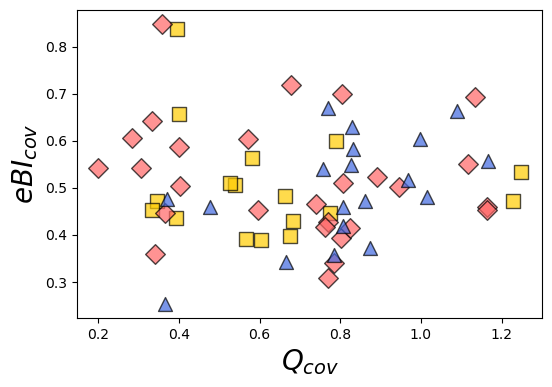

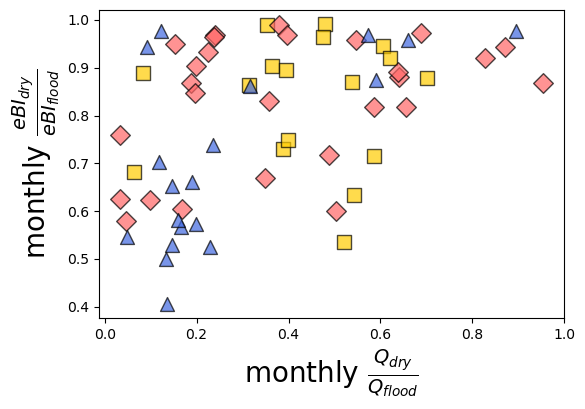

In [133]:
statistics_df['low_high_mean'] = statistics_df['Mean_Low_Flow_Discharge'] / statistics_df['Mean_High_Flow_Discharge']

fig1=plt.figure(figsize=(6, 4))
fig2=plt.figure(figsize=(6, 4))

ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)

markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}  
for cls in markers:
    ax1.scatter(statistics_df[statistics_df['Classification'] == cls]['Cov_Discharge'], 
                statistics_df[statistics_df['Classification'] == cls]['Coeff_Variation_ebi'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax2.scatter(statistics_df[statistics_df['Classification'] == cls]['low_high_mean'], 
                statistics_df[statistics_df['Classification'] == cls]['Month_diff'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers

ax1.set_xlabel(r'${Q_{cov}}$', fontsize=20)
ax1.set_ylabel(r'${eBI_{cov}}$', fontsize=20)

ax2.set_xlabel(r'monthly $\frac{Q_{dry}}{Q_{flood}}$', fontsize=20)
ax2.set_ylabel(r'monthly $\frac{eBI_{dry}}{eBI_{flood}}$', fontsize=20)
#ax2.set_xscale('log')
#for i, row in statistics_df.iterrows():
    #ax2.annotate(row['River'], (row['low_high_mean'], row['Month_diff']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)


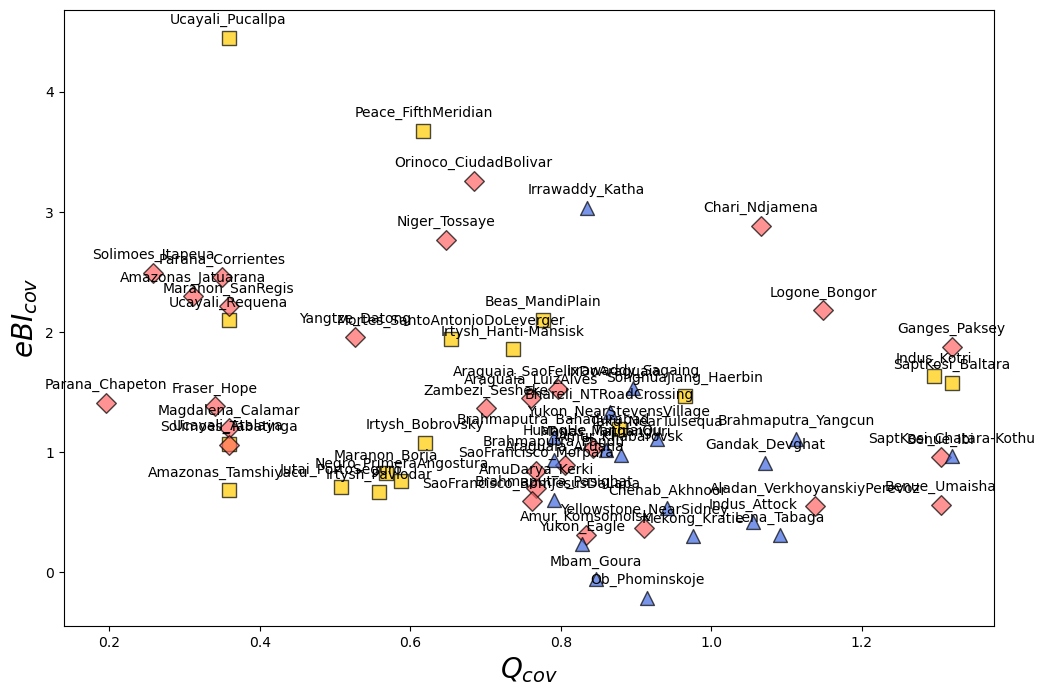

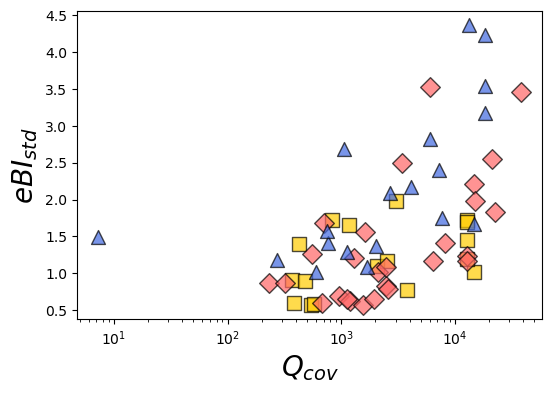

In [602]:
fig1=plt.figure(figsize=(12, 8))
fig2=plt.figure(figsize=(6, 4))

ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)

markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}  
for cls in markers:
    ax1.scatter(statistics_df[statistics_df['Classification'] == cls]['Coeff_Variation_discharge'], 
                statistics_df[statistics_df['Classification'] == cls]['Skewness_eBI'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax2.scatter(statistics_df[statistics_df['Classification'] == cls]['Std_discharge'], 
                statistics_df[statistics_df['Classification'] == cls]['Std_eBI'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers

ax1.set_xlabel(r'${Q_{skew}}$', fontsize=20)
ax1.set_ylabel(r'${eBI_{cov}}$', fontsize=20)

ax2.set_xlabel(r'${Q_{cov}}$', fontsize=20)
ax2.set_ylabel(r'${eBI_{std}}$', fontsize=20)
ax2.set_xscale('log')
for i, row in statistics_df.iterrows():
    ax1.annotate(row['River'], (row['Coeff_Variation_discharge'], row['Skewness_eBI']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)


#### BI and eBI relationships

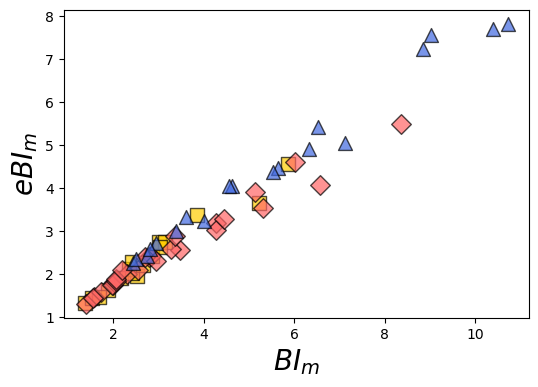

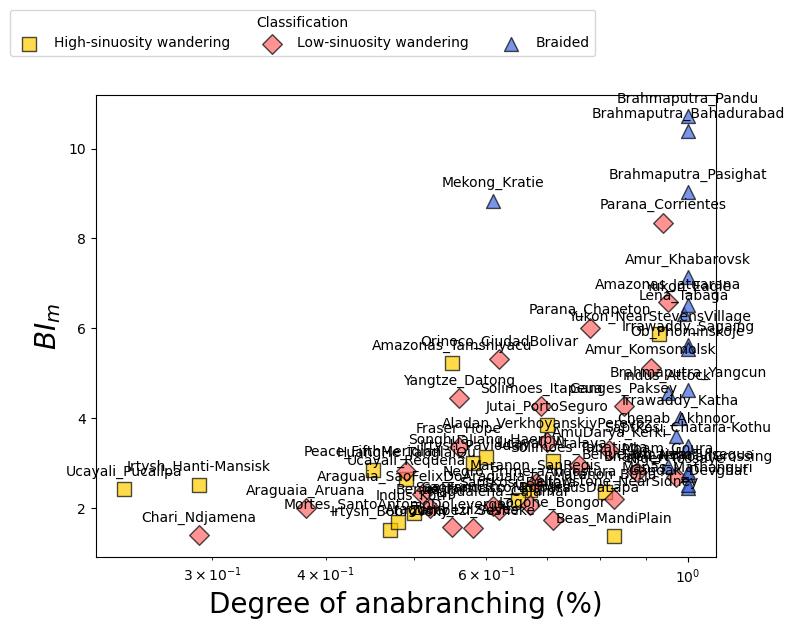

In [9]:
fig1=plt.figure(figsize=(6, 4))
fig2=plt.figure(figsize=(8, 6))

ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)

markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}  
for cls in markers:
    ax1.scatter(statistics_df[statistics_df['Classification'] == cls]['Mean_BI'], 
                statistics_df[statistics_df['Classification'] == cls]['Mean_eBI'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax2.scatter(statistics_df[statistics_df['Classification'] == cls]['Degree_anabranching'], 
                statistics_df[statistics_df['Classification'] == cls]['Mean_BI'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers

ax1.set_xlabel(r'${BI_{m}}$', fontsize=20)
ax1.set_ylabel(r'${eBI_{m}}$', fontsize=20)
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}
legend = plt.legend(title='Classification', loc='upper left', bbox_to_anchor=(-0.15,1.2), ncol=len(markers), labels=planform_type.values())

ax2.set_xlabel(r'Degree of anabranching (%)', fontsize=20)
ax2.set_ylabel(r'${BI_{m}}$', fontsize=20)
ax2.set_xscale('log')

# plt.setp(legend.get_title(), fontsize='14')  # Set legend title fontsize
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

for i, row in statistics_df.iterrows():
    ax2.annotate(row['River'], (row['Degree_anabranching'], row['Mean_BI']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

#### Qm (mean monthly discharge)

HSW slope: 0.32
LSW slope: 0.42
B slope: 1.25


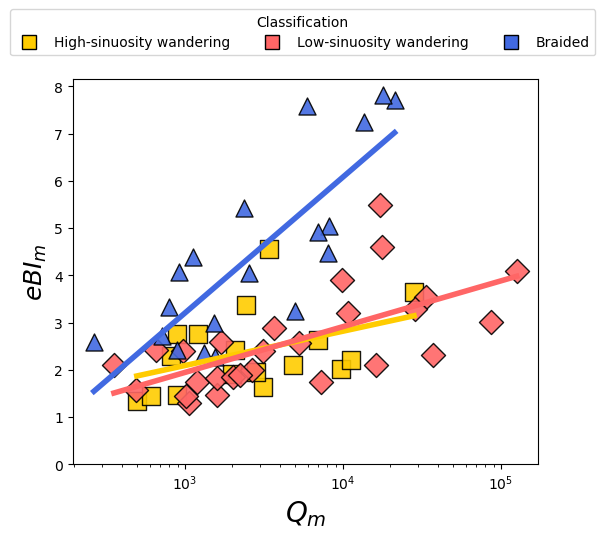

In [34]:
statistics_df['mean_ebi_bi'] = statistics_df['Mean_eBI'] / statistics_df['Mean_BI']

# Function to fit a regression line and return the line's coordinates
def fit_regression(x_data, y_data):
    # Apply logarithmic transformation to x_data
    log_x_data = np.log(x_data)
    # Fit the linear regression model
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    print(f"{cls} slope: {slope:.2f}")
    # Create points for the regression line
    line_x = np.linspace(log_x_data.min(), log_x_data.max(), 100)
    line_y = slope * line_x + intercept
    return np.exp(line_x), line_y, std_err  # Transform the line_x back to the original scale

# Create the figure and axis
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}


for cls in markers:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Qm']
    y_data = subset['Mean_eBI']
    line_x, line_y, std_err = fit_regression(x_data, y_data)
    ax.plot(line_x, line_y, color=colors[cls], lw=4)
    ax.scatter(statistics_df[statistics_df['Classification'] == cls]['Qm'], 
                   statistics_df[statistics_df['Classification'] == cls]['Mean_eBI'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9) 
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}

# Create custom legends for scatter points
legend_elements = [Line2D([0], [0], marker='s', color='w', label=planform_type[cls],
                          markerfacecolor=colors[cls], markersize=10, markeredgecolor='black') 
                   for cls in markers]

# Add the custom legends for scatter points
legend=ax.legend(handles=legend_elements, title='Classification', loc='upper left', ncol=len(markers), bbox_to_anchor=(-0.15,1.2))


# Set log scale for x-axis and labels for axes
ax.set_xscale('log')
ax.set_ylim(bottom=0)
ax.set_xlabel(r'${Q_{m}}$', fontsize=20)
ax.set_ylabel(r'${eBI_{m}}$', fontsize=18)

plt.show()


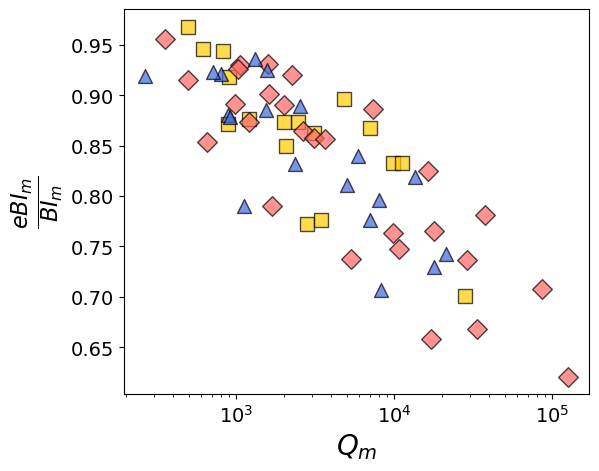

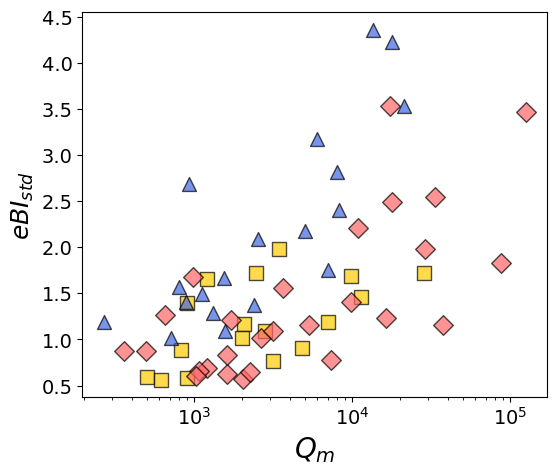

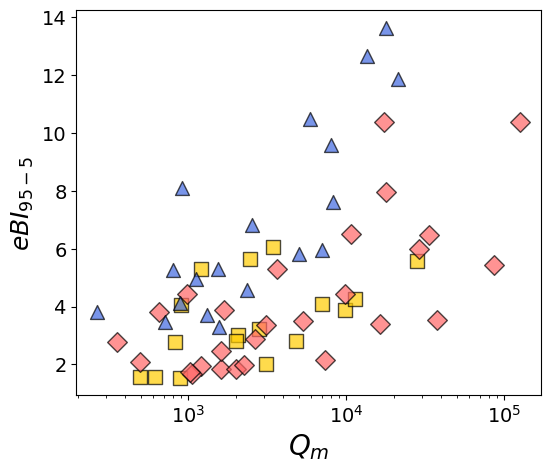

In [31]:
statistics_df['range_ebi_bi'] = statistics_df['eBI_range'] / statistics_df['Mean_BI']


fig2 = plt.figure(figsize=(6, 5))
fig3 = plt.figure(figsize=(6, 5))
fig4 = plt.figure(figsize=(6, 5))

markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}  

ax2 = fig2.add_subplot(111)
ax3 = fig3.add_subplot(111)
ax4 = fig4.add_subplot(111)

def annotate_slope(ax, cls, slope):
    # Annotate slope
    ax.annotate(f'{cls} slope: {slope:.2f}',
                xy=(0.05, 0.95), xycoords='axes fraction', 
                ha='left', va='top', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[cls], facecolor='white'))

# Fit and plot regression lines for each classification
for cls in markers:

    ax2.scatter(statistics_df[statistics_df['Classification'] == cls]['Qm'], 
                   statistics_df[statistics_df['Classification'] == cls]['mean_ebi_bi'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax3.scatter(statistics_df[statistics_df['Classification'] == cls]['Qm'], 
                   statistics_df[statistics_df['Classification'] == cls]['Std_eBI'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax4.scatter(statistics_df[statistics_df['Classification'] == cls]['Qm'], 
                   statistics_df[statistics_df['Classification'] == cls]['eBI_range'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers



ax1.set_xlabel(r'${Q_{m}}$', fontsize=20)
ax1.set_ylabel(r'${eBI_{m}}$', fontsize=18)
ax2.set_xlabel(r'${Q_{m}}$', fontsize=20)
ax2.set_ylabel(r'$\frac{eBI_{m}}{BI_{m}}$', fontsize=23)
ax3.set_xlabel(r'${Q_{m}}$', fontsize=20)
ax3.set_ylabel(r'${eBI_{std}}$', fontsize=18)
ax4.set_xlabel(r'${Q_{m}}$', fontsize=20)
ax4.set_ylabel(r'${eBI_{95-5}}$', fontsize=18)

planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}

for ax in [ax1, ax2, ax3,ax4]:
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)

# for i, row in statistics_df.iterrows():
#     ax1.annotate(row['River'], (row['Qm'], row['Mean_eBI']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)
#     ax2.annotate(row['River'], (row['Qm'], row['mean_ebi_bi']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}
legend = ax1.legend(title='Classification', loc='upper left', bbox_to_anchor=(-0.15,1.2), ncol=len(markers), labels=planform_type.values())

plt.show()

#save figure
# fig1.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\mean_eBI_Q.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)
# fig1.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\mean_eBI_Q.tif", format='tif', dpi=500, bbox_inches='tight')
# fig2.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\mean_eBI_BI.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)
# fig2.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\mean_eBI_BI.tif", format='tif', dpi=500, bbox_inches='tight')


#### Qmin/Qmax (min monthly vs max monthly dishcarge)

KeyError: 'mean_ebi_bi'

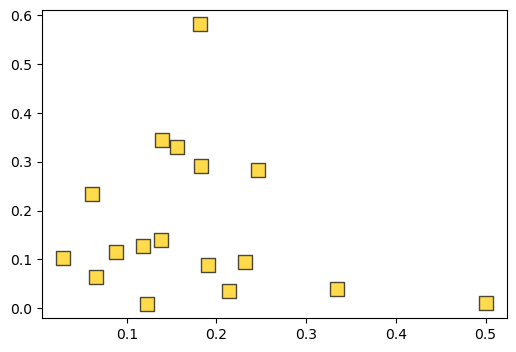

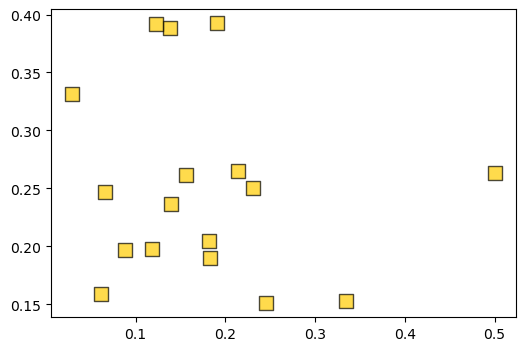

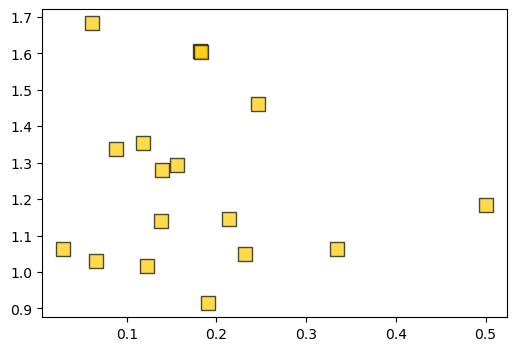

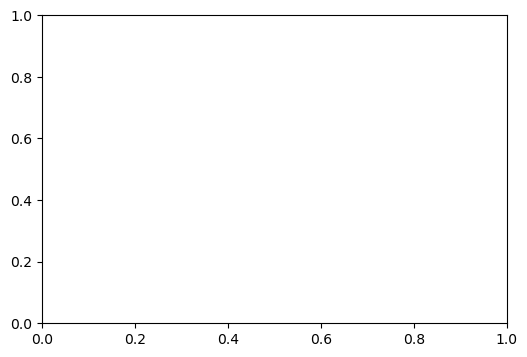

In [596]:
statistics_df['Qmin_to_Qmax_ratio'] = statistics_df['Qmin'] / statistics_df['Qmax']
statistics_df['month_diff_mean_bi'] = statistics_df['Month_diff'] / statistics_df['Mean_BI']
statistics_df['ebi_min_max'] = statistics_df['Percentile_5'] / statistics_df['Percentile_95']
statistics_df['percent_diff_mean_bi'] = statistics_df['eBI_range'] / statistics_df['Mean_BI']

fig1=plt.figure(figsize=(6, 4))
fig2=plt.figure(figsize=(6, 4))
fig3=plt.figure(figsize=(6, 4))
fig4=plt.figure(figsize=(6, 4))
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
ax3 = fig3.add_subplot(111)
ax4 = fig4.add_subplot(111)
markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}  
for cls in markers:
    ax1.scatter(statistics_df[statistics_df['Classification'] == cls]['Qmin_to_Qmax_ratio'], 
                statistics_df[statistics_df['Classification'] == cls]['month_diff_mean_bi'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax2.scatter(statistics_df[statistics_df['Classification'] == cls]['Qmin_to_Qmax_ratio'], 
                statistics_df[statistics_df['Classification'] == cls]['ebi_min_max'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax3.scatter(statistics_df[statistics_df['Classification'] == cls]['Qmin_to_Qmax_ratio'], 
                statistics_df[statistics_df['Classification'] == cls]['percent_diff_mean_bi'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax4.scatter(statistics_df[statistics_df['Classification'] == cls]['Qmin_to_Qmax_ratio'], 
                statistics_df[statistics_df['Classification'] == cls]['mean_ebi_bi'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers


ax1.set_xlabel(r'$\frac{Q_{min}}{Q_{max}}$', fontsize=20)
ax1.set_ylabel(r'$\frac{\mathit{eBI}_{max} - \mathit{eBI}_{min}}{\mathit{BI}_{m}}$', fontsize=18)
ax2.set_xlabel(r'$\frac{Q_{min}}{Q_{max}}$', fontsize=20)
ax2.set_ylabel(r'$\frac{eBI_{5}}{eBI_{95}}$', fontsize=18)
ax3.set_xlabel(r'$\frac{Q_{min}}{Q_{max}}$', fontsize=20)
ax3.set_ylabel(r'$\frac{eBI_{95-5}}{BI_{mean}}$', fontsize=18)
ax4.set_xlabel(r'$\frac{Q_{min}}{Q_{max}}$', fontsize=20)
ax4.set_ylabel(r'$\frac{eBI_{m}}{BI_{m}}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}
legend = ax1.legend(title='Classification', loc='upper left', bbox_to_anchor=(-0.15,1.2), ncol=len(markers), labels=planform_type.values())

#save figure

# plt.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\month_diff_eBI.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)
# plt.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\month_diff_eBI.tif", format='tif', dpi=500, bbox_inches='tight')




#### Qmax vs Qm (max monthly vs mean monthly discharge)

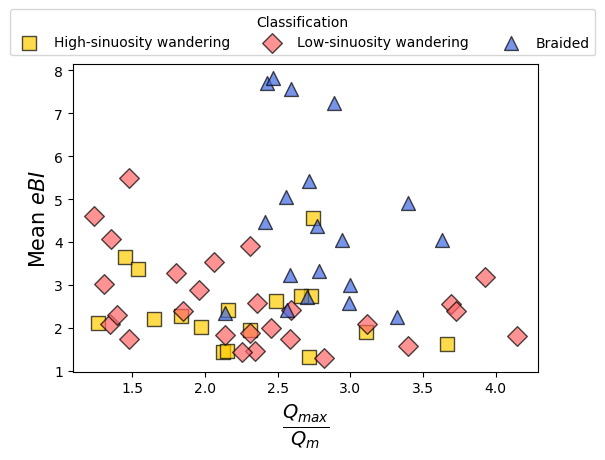

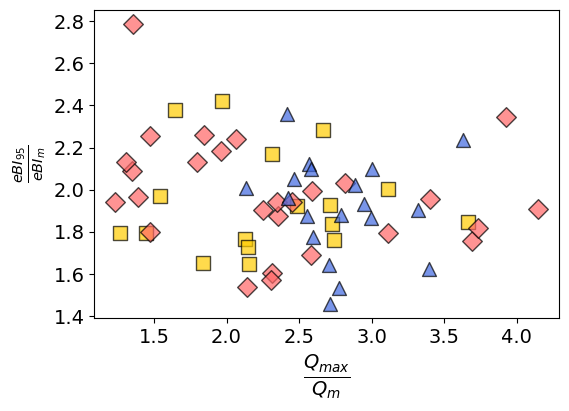

In [408]:
# ratio of Qmax to Qm
statistics_df['Qmax_to_Qm_ratio'] = statistics_df['Qmax'] / statistics_df['Qm']
statistics_df['eBI_max_mean'] = statistics_df['Percentile_95'] / statistics_df['Mean_eBI']

fig1 =plt.figure(figsize=(6, 4))
fig2=plt.figure(figsize=(6, 4))
# fig3=plt.figure(figsize=(6, 4))

ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
# ax3 = fig3.add_subplot(111)

markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}  
for cls in markers:
    ax1.scatter(statistics_df[statistics_df['Classification'] == cls]['Qmax_to_Qm_ratio'], 
                statistics_df[statistics_df['Classification'] == cls]['Mean_eBI'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax2.scatter(statistics_df[statistics_df['Classification'] == cls]['Qmax_to_Qm_ratio'], 
                statistics_df[statistics_df['Classification'] == cls]['eBI_max_mean'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    #ax3.scatter(statistics_df[statistics_df['Classification'] == cls]['Qmax_to_Qm_ratio'], 
                #statistics_df[statistics_df['Classification'] == cls]['mean_ebi_bi'], 
                #label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers

# Add labels and legend
ax1.set_xlabel(r'$\frac{Q_{max}}{Q_{m}}$', fontsize=20)
ax1.set_ylabel('Mean $\mathit{eBI}$', fontsize=15)
ax2.set_xlabel(r'$\frac{Q_{max}}{Q_{m}}$', fontsize=20)
ax2.set_ylabel(r'$\frac{eBI_{95}}{eBI_{m}}$', fontsize=15)
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}
legend = ax1.legend(title='Classification', loc='upper left', bbox_to_anchor=(-0.15,1.2), ncol=len(markers), labels=planform_type.values())
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


#### including meandering rivers from Austin's PIV dataset

['Beni_Rurrenabaque', 'Bermejo_ElColorado', 'Corrientes_PasoLucero', 'Cuiaba_PortoCercado', 'Desna_Kolychovka', 'Irtysh_Tobolsk', 'Jurua_CruzeiroDoSul', 'Jurua_EirunepeMontante', 'Jurua_Gaviao', 'Jurua_SantosDumont', 'Jurua_Thaumaturgo', 'Mamore_Guajara-Mirim', 'Mamore_PuertoSiles', 'Pilcomayo_LaPaz', 'Purus_SeringalFortaleza', 'Purus_ValparaisoMontante', 'Red_Index', 'Sepik_Ambunti', 'Zambezi_Senanga']


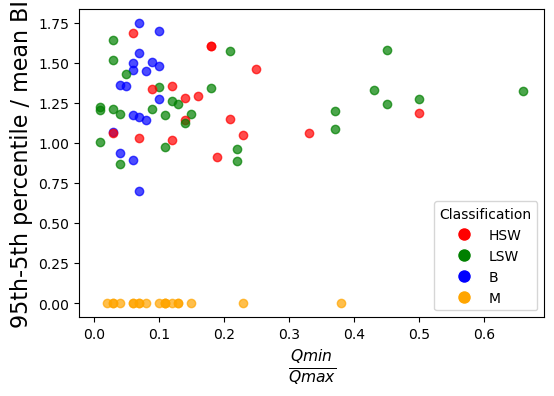

In [180]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file containing river names, aridity index values, classifications, and "PIV?" column
river_file = r"C:\Users\Feifei\PHD\Landsat_watermasks\Galeazzi_eBI.csv"
river_df = pd.read_csv(river_file)

river_dict = {}
for index, row in river_df.iterrows():
    river_name = row['River_Station']
    qmin_qmax = row['Qmin_Qmax']
    anabranching = row['Degree_anabranching']
    classification = row['Classification']  # Read Classification column
    piv = row['PIV?']  # Read "PIV?" column
    river_dict[river_name] = (qmin_qmax, anabranching, classification, piv)

# Lists to store data for plotting
qmin_qmax_values = []
anabranching_values = []
eBI_differences_list = []
river_names = []
classifications = []  # Store classifications for coloring
mean_bi_values = []  # Store mean BI values

root_dir = r'C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results'


# Iterate through each river in the loaded CSV file
for river_name, (qmin_qmax, anabranching, classification, piv) in river_dict.items():
    # Check if the river has classification "M" and "PIV?" as "Y"
    if classification == "M" and piv == "Y":
        found_m_rivers = True
        # Add the river to the plot with an eBI difference of 0
        river_names.append(river_name)
        classifications.append(classification)
        eBI_differences_list.append(0)
        qmin_qmax_values.append(qmin_qmax)
        anabranching_values.append(anabranching)
# After your loop
print(river_names)

# Iterate through each river folder
for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            ebi_csv_path = os.path.join(rivgraph_path, 'eBI_results.csv')
            bi_csv_path = os.path.join(rivgraph_path, 'BI_results.csv')
            
            # Check if both eBI_results.csv and BI_results.csv exist
            if os.path.exists(ebi_csv_path) and os.path.exists(bi_csv_path):
                try:
                    # Read eBI_results.csv
                    ebi_df = pd.read_csv(ebi_csv_path)

                    # Compute the 95th and 5th percentiles of all eBI values
                    percentile_95 = np.percentile(ebi_df['eBI'], 95)
                    percentile_5 = np.percentile(ebi_df['eBI'], 5)
                    eBI_difference = percentile_95 - percentile_5
                    #print(f"95th percentile: {percentile_95}, 5th percentile: {percentile_5}")
                    #print(f"eBI difference: {eBI_difference}")

                    # Read BI_results.csv and calculate mean BI values
                    bi_df = pd.read_csv(bi_csv_path)
                    mean_bi = bi_df['BI'].mean()
                    #print(f"Mean BI: {mean_bi}")

                    # Store mean BI value
                    mean_bi_values.append(mean_bi)

                    # Store river name, aridity index, and classification
                    river_name = river_folder
                    qmin_qmax, anabranching, classification = river_aridity_dict.get(river_name, (np.nan, np.nan, np.nan, np.nan))
                    qmin_qmax_values.append(qmin_qmax)
                    anabranching_values.append(anabranching)
                    river_names.append(river_folder)
                    classifications.append(classification)  # Store classification

                    # Divide mean BI from the difference of 95th and 5th percentiles of eBI
                    eBI_differences_list.append(eBI_difference / mean_bi)

                except Exception as e:
                    print(f"Error processing {river_folder}: {e}")


# Proceed with plotting...
# Define color mapping for classifications
color_mapping = {'HSW': 'red', 'LSW': 'green', 'B': 'blue', 'M': 'orange'}

# Create scatter plot colored by classification for Qmin/Qmax
plt.figure(figsize=(6, 4))
for classification, x, y, name in zip(classifications, qmin_qmax_values, eBI_differences_list, river_names):
    plt.scatter(x, y, c=color_mapping.get(classification, 'black'), alpha=0.7)
    #plt.text(x, y, name, fontsize=8)  # Add river name as text label

# Add labels and title
plt.xlabel(r'$\frac{Qmin}{Qmax}$', fontsize=16)
plt.ylabel('95th-5th percentile / mean BI', fontsize=16)

# Add legend for classifications
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key,
                                   markerfacecolor=color_mapping[key], markersize=10) for key in color_mapping.keys()]
plt.legend(handles=legend_elements, title='Classification')

plt.show()



#### experimenting with rBI (dependent on timescale)

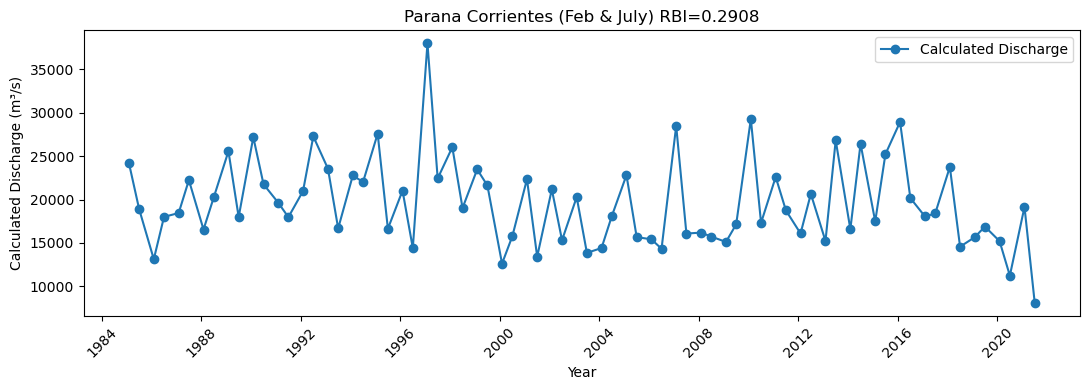

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data, assuming the text file is named 'data.txt'
# Adjust the file path as necessary
file_path = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Parana_Corrientes\3265300_Q_Month.txt"
data = pd.read_csv(file_path, delimiter=';', comment='#', skip_blank_lines=True, encoding='ISO-8859-1')

# Preprocessing
data['Date'] = pd.to_datetime(data['YYYY-MM-DD'], format='%Y-%m-%d')
data['Year'] = data['Date'].dt.year

# Filter by date to include only February and July, starting from 1985
data_filtered = data[((data['Date'].dt.month == 2) | (data['Date'].dt.month == 7)) & (data['Year'] >= 1985)]

# Calculate the absolute differences between consecutive discharge values
abs_diff = data_filtered[' Calculated'].diff().abs().sum()

# Calculate the total sum of discharge values
total_sum = data_filtered[' Calculated'].sum()

# Calculate the Richards-Baker flashiness index
richards_baker_index = abs_diff / total_sum

# No need to separate by month now, since each point will be distinct
plt.figure(figsize=(11, 4))

# Plotting
plt.plot(data_filtered['Date'], data_filtered[' Calculated'], label='Calculated Discharge', marker='o', linestyle='-')


plt.xlabel('Year')
plt.ylabel('Calculated Discharge (m³/s)')
plt.title(f'Parana Corrientes (Feb & July) RBI={richards_baker_index:.4f}')  
plt.legend()
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to not cut off labels
plt.show()



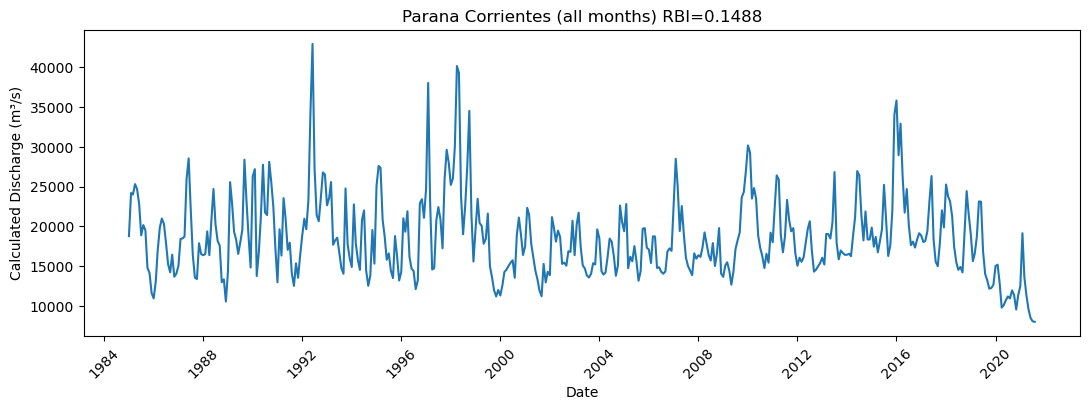

In [11]:
# Convert date column to datetime type
data['Date'] = pd.to_datetime(data['YYYY-MM-DD'], format='%Y-%m-%d')

# Filter to include all entries from 1985 onwards
data_filtered = data[data['Date'].dt.year >= 1985]

# Plotting
plt.figure(figsize=(11, 4))
plt.plot(data_filtered['Date'], data_filtered[' Calculated'], label='Calculated Discharge', marker=None, linestyle='-')

plt.xlabel('Date')
plt.ylabel('Calculated Discharge (m³/s)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels

# Calculate the Richards-Baker flashiness index
abs_diff = data_filtered[' Calculated'].diff().abs().sum()
total_sum = data_filtered[' Calculated'].sum()
richards_baker_index = abs_diff / total_sum

# Add the Richards-Baker Index to the title with calculated index
plt.title(f'Parana Corrientes (all months) RBI={richards_baker_index:.4f}')  
plt.show()

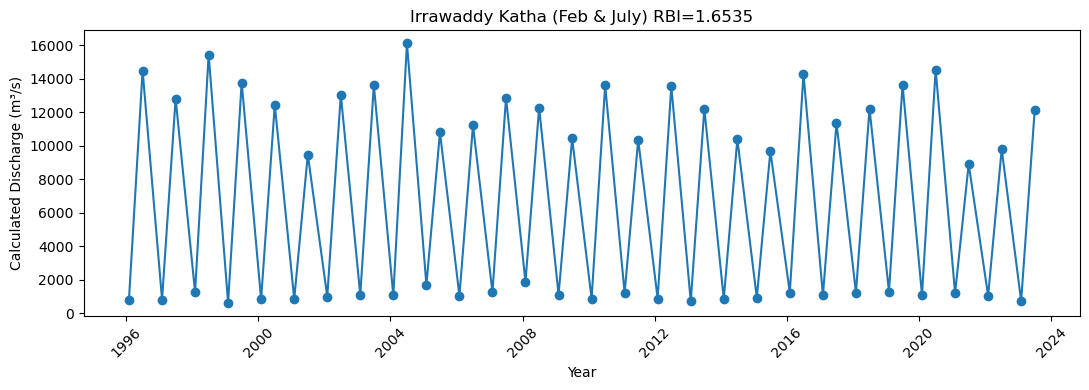

In [16]:
# Load the data, assuming the text file is named 'data.txt'
# Adjust the file path as necessary
file_path = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Irrawaddy_Katha\2260400_Q_Month.txt"
data = pd.read_csv(file_path, delimiter=';', comment='#', skip_blank_lines=True, encoding='ISO-8859-1')

# Preprocessing
data['Date'] = pd.to_datetime(data['YYYY-MM-DD'], format='%Y-%m-%d')
data['Year'] = data['Date'].dt.year

# Filter by date to include only February and July, starting from 1985
data_filtered = data[((data['Date'].dt.month == 2) | (data['Date'].dt.month == 7)) & (data['Year'] >= 1985)]

# Calculate the absolute differences between consecutive discharge values
abs_diff = data_filtered[' Calculated'].diff().abs().sum()

# Calculate the total sum of discharge values
total_sum = data_filtered[' Calculated'].sum()

# Calculate the Richards-Baker flashiness index
richards_baker_index = abs_diff / total_sum

# No need to separate by month now, since each point will be distinct
plt.figure(figsize=(11, 4))

# Plotting
plt.plot(data_filtered['Date'], data_filtered[' Calculated'], label='Calculated Discharge', marker='o', linestyle='-')


plt.xlabel('Year')
plt.ylabel('Calculated Discharge (m³/s)')
plt.title(f'Irrawaddy Katha (Feb & July) RBI={richards_baker_index:.4f}')  
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to not cut off labels
plt.show()


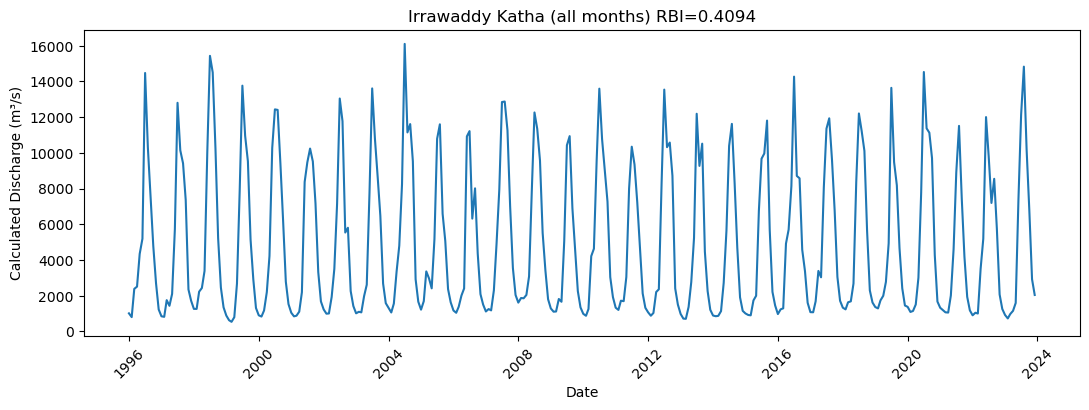

In [15]:
# Convert date column to datetime type
data['Date'] = pd.to_datetime(data['YYYY-MM-DD'], format='%Y-%m-%d')

# Filter to include all entries from 1985 onwards
data_filtered = data[data['Date'].dt.year >= 1985]

# Plotting
plt.figure(figsize=(11, 4))
plt.plot(data_filtered['Date'], data_filtered[' Calculated'], label='Calculated Discharge', marker=None, linestyle='-')

plt.xlabel('Date')
plt.ylabel('Calculated Discharge (m³/s)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels

# Calculate the Richards-Baker flashiness index
abs_diff = data_filtered[' Calculated'].diff().abs().sum()
total_sum = data_filtered[' Calculated'].sum()
richards_baker_index = abs_diff / total_sum

# Add the Richards-Baker Index to the title with calculated index
plt.title(f'Irrawaddy Katha (all months) RBI={richards_baker_index:.4f}')  
plt.show()

### plotting Simon's dataset

In [418]:

# Read the metadata CSV
metadata_csv_path = "C:\\Users\\Feifei\\Box\\BR_remote_sensing\\Simon_waterdischarge_daily\\OHDB_PIV_poly_manual_match_w_metadata.csv"
metadata_df = pd.read_csv(metadata_csv_path)

# Convert 'ohdb_start_year' and 'ohdb_end_year' columns to numeric
metadata_df['ohdb_start_year'] = pd.to_numeric(metadata_df['ohdb_start_year'], errors='coerce')
metadata_df['ohdb_end_year'] = pd.to_numeric(metadata_df['ohdb_end_year'], errors='coerce')

# Filter sites with any overlap between 1985 and 2022
sites_with_overlap = metadata_df[((metadata_df['ohdb_start_year'] >= 1985) & (metadata_df['ohdb_start_year'] <= 2022)) | ((metadata_df['ohdb_end_year'] >= 1985) & (metadata_df['ohdb_end_year'] <= 2022))]

# Calculate duration of coverage
sites_with_overlap['coverage_duration'] = sites_with_overlap.apply(lambda row: min(row['ohdb_end_year'], 2022) - max(row['ohdb_start_year'], 1985) + 1, axis=1)

# Sort sites by coverage duration (from most to least)
sites_with_overlap = sites_with_overlap.sort_values(by='coverage_duration', ascending=False)

# Print sites with Landsat coverage (ranked from most to least coverage)
print("Sites with Landsat coverage (ranked from most to least coverage):")
for index, row in sites_with_overlap.iterrows():
    print(f"- {row['site']}: {row['coverage_duration']} years of coverage (from {row['ohdb_start_year']} to {row['ohdb_end_year']})")


Sites with Landsat coverage (ranked from most to least coverage):
- Irrawaddy_Sagaing: 38 years of coverage (from 1978 to 2022)
- Koyukuk: 38 years of coverage (from 1960 to 2022)
- SaoFrancisco_Morpara: 37 years of coverage (from 1945 to 2021)
- Magdalena_Calamar: 37 years of coverage (from 1940 to 2021)
- Pilcomayo_LaPaz: 37 years of coverage (from 1941 to 2021)
- Mamore: 37 years of coverage (from 1970 to 2021)
- Mamore_Guajara-Mirim: 37 years of coverage (from 1970 to 2021)
- Parana_Chapeton: 37 years of coverage (from 1975 to 2021)
- Mamore_PuertoSiles: 37 years of coverage (from 1970 to 2021)
- Madeira_Humaita: 37 years of coverage (from 1967 to 2021)
- Fraser_Hope: 37 years of coverage (from 1912 to 2021)
- Parana_Corrientes: 37 years of coverage (from 1904 to 2021)
- Solimoes_SantoAntonioDoIca: 36 years of coverage (from 1972 to 2020)
- Beni_Rurrenabaque: 36 years of coverage (from 1976 to 2020)
- Amazonas_Obidos: 36 years of coverage (from 1968 to 2020)
- Krishna_Vijayawada: 3

C:\Users\Feifei\AppData\Local\Temp\ipykernel_21856\1955781832.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sites_with_overlap['coverage_duration'] = sites_with_overlap.apply(lambda row: min(row['ohdb_end_year'], 2022) - max(row['ohdb_start_year'], 1985) + 1, axis=1)


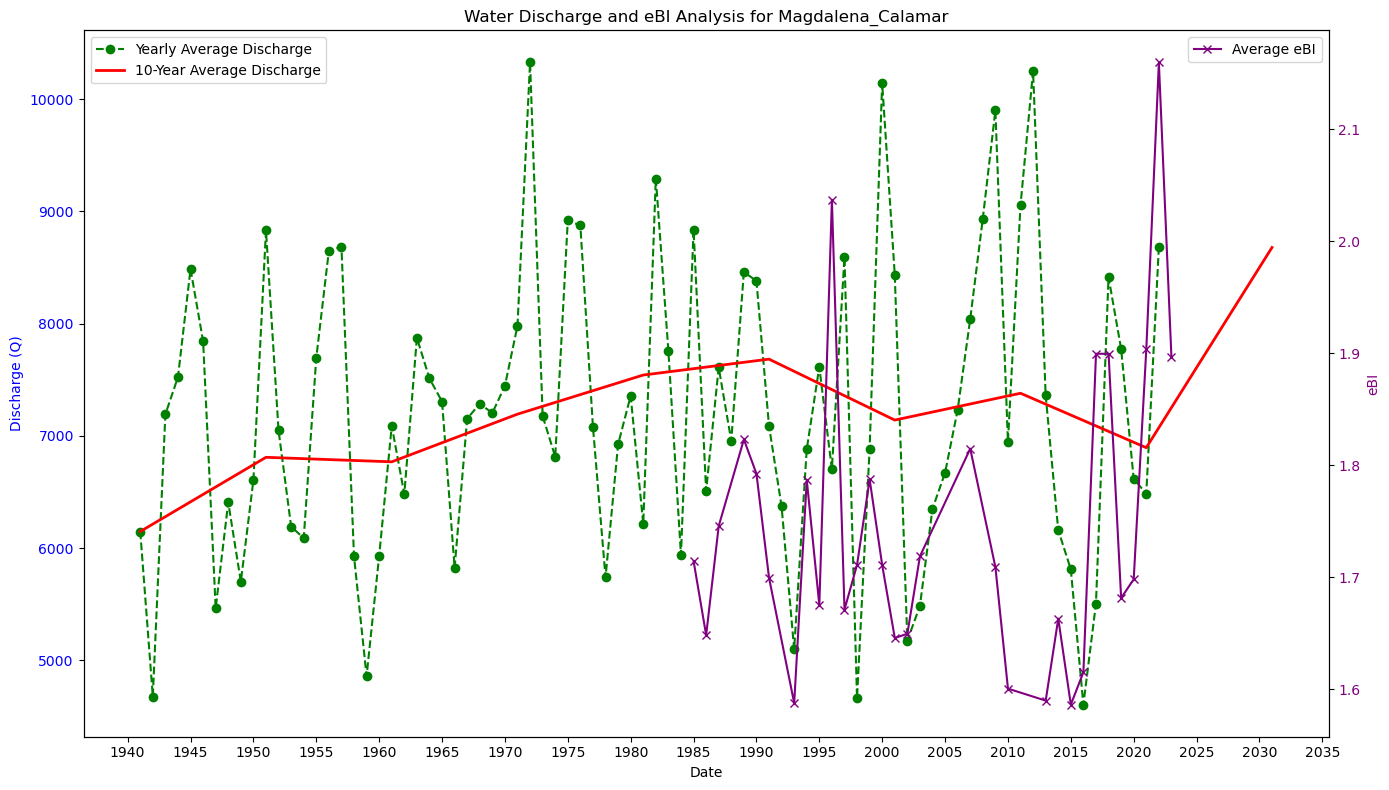

In [427]:

# Define the paths
metadata_csv_path = "C:\\Users\\Feifei\\Box\\BR_remote_sensing\\Simon_waterdischarge_daily\\OHDB_PIV_poly_manual_match_w_metadata.csv"
discharge_data_dir = "C:\\Users\\Feifei\\Box\\BR_remote_sensing\\Simon_waterdischarge_daily\\PIV_polygon_ts"
ebi_csv_path = "C:\\Users\\Feifei\\PHD\\Landsat_watermasks\\ebi_results\\Magdalena_Calamar\\rivgraph\\eBI_results.csv"

# Site of interest
site_of_interest = "Magdalena_Calamar"

# Read the metadata CSV
metadata_df = pd.read_csv(metadata_csv_path)

# Get ohdb_id for the site of interest
ohdb_id = metadata_df.loc[metadata_df['site'] == site_of_interest, 'ohdb_id'].values[0]

# Construct the path to the water discharge CSV and read the data
discharge_csv_path = os.path.join(discharge_data_dir, f"{ohdb_id}.csv")
discharge_df = pd.read_csv(discharge_csv_path)

# Convert 'date' column to datetime format and set as index
discharge_df['date'] = pd.to_datetime(discharge_df['date'])
discharge_df.set_index('date', inplace=True)

# Resampling
daily_discharge = discharge_df['Q']
yearly_discharge = discharge_df['Q'].resample('Y').mean()
ten_year_discharge = discharge_df['Q'].resample('10Y').mean()

# Read the eBI data and correct year handling
ebi_df = pd.read_csv(ebi_csv_path)
ebi_df['Year'] = pd.to_datetime(ebi_df['Year'], format='%Y')  # Ensure Year is datetime
avg_ebi_per_year = ebi_df.groupby(ebi_df['Year'])['eBI'].mean()

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot discharge data
#ax1.plot(daily_discharge.index, daily_discharge, label='Daily Discharge', alpha=0.5, color='blue')
ax1.plot(yearly_discharge.index, yearly_discharge, label='Yearly Average Discharge', color='green', marker='o', linestyle='--')
ax1.plot(ten_year_discharge.index, ten_year_discharge, label='10-Year Average Discharge', color='red', linewidth=2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (Q)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Secondary Y-axis for eBI
ax2 = ax1.twinx()
ax2.plot(avg_ebi_per_year.index, avg_ebi_per_year, label='Average eBI', color='purple', marker='x', linestyle='-')
ax2.set_ylabel('eBI', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

# Improve formatting
ax1.xaxis.set_major_locator(mdates.YearLocator(5))  # Show a year tick every 5 years
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.title(f"Water Discharge and eBI Analysis for {site_of_interest}")
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()




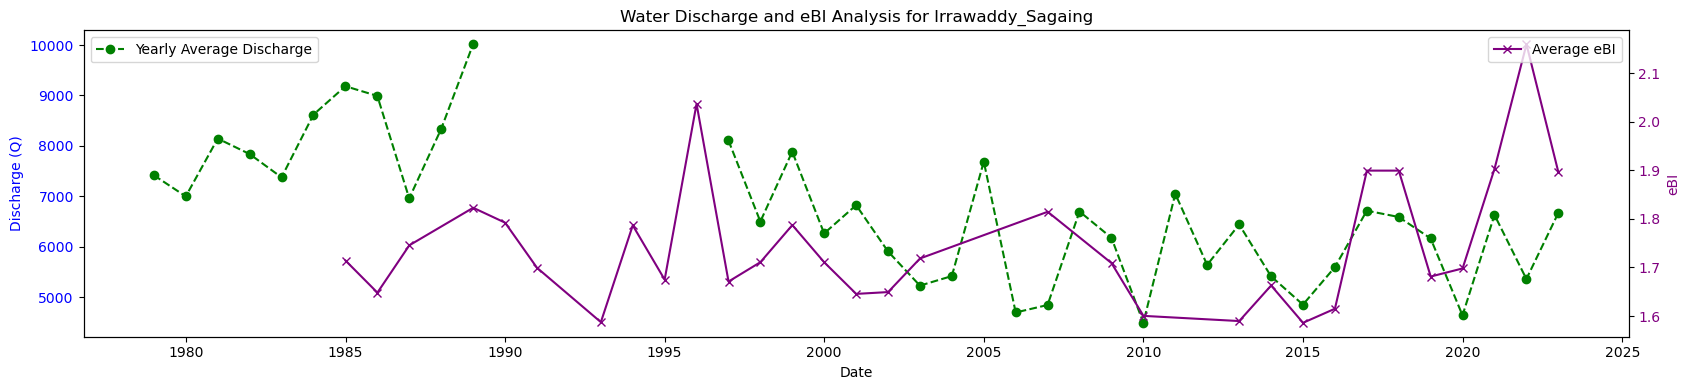

In [428]:

# Define the paths
metadata_csv_path = "C:\\Users\\Feifei\\Box\\BR_remote_sensing\\Simon_waterdischarge_daily\\OHDB_PIV_poly_manual_match_w_metadata.csv"
discharge_data_dir = "C:\\Users\\Feifei\\Box\\BR_remote_sensing\\Simon_waterdischarge_daily\\PIV_polygon_ts"
ebi_csv_path = "C:\\Users\\Feifei\\PHD\\Landsat_watermasks\\ebi_results\\Magdalena_Calamar\\rivgraph\\eBI_results.csv"

# Site of interest
site_of_interest = "Irrawaddy_Sagaing"

# Read the metadata CSV
metadata_df = pd.read_csv(metadata_csv_path)

# Get ohdb_id for the site of interest
ohdb_id = metadata_df.loc[metadata_df['site'] == site_of_interest, 'ohdb_id'].values[0]

# Construct the path to the water discharge CSV and read the data
discharge_csv_path = os.path.join(discharge_data_dir, f"{ohdb_id}.csv")
discharge_df = pd.read_csv(discharge_csv_path)

# Convert 'date' column to datetime format and set as index
discharge_df['date'] = pd.to_datetime(discharge_df['date'])
discharge_df.set_index('date', inplace=True)

# Resampling
daily_discharge = discharge_df['Q']
yearly_discharge = discharge_df['Q'].resample('Y').mean()
#ten_year_discharge = discharge_df['Q'].resample('10Y').mean()

# Read the eBI data and correct year handling
ebi_df = pd.read_csv(ebi_csv_path)
ebi_df['Year'] = pd.to_datetime(ebi_df['Year'], format='%Y')  # Ensure Year is datetime
avg_ebi_per_year = ebi_df.groupby(ebi_df['Year'])['eBI'].mean()

# Create the plot
fig, ax1 = plt.subplots(figsize=(17, 4))

# Plot discharge data
#ax1.plot(daily_discharge.index, daily_discharge, label='Daily Discharge', alpha=0.5, color='blue')
ax1.plot(yearly_discharge.index, yearly_discharge, label='Yearly Average Discharge', color='green', marker='o', linestyle='--')
#ax1.plot(ten_year_discharge.index, ten_year_discharge, label='10-Year Average Discharge', color='red', linewidth=2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (Q)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Secondary Y-axis for eBI
ax2 = ax1.twinx()
ax2.plot(avg_ebi_per_year.index, avg_ebi_per_year, label='Average eBI', color='purple', marker='x', linestyle='-')
ax2.set_ylabel('eBI', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

# Improve formatting
ax1.xaxis.set_major_locator(mdates.YearLocator(5))  # Show a year tick every 5 years
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.title(f"Water Discharge and eBI Analysis for {site_of_interest}")
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()
